<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe. </font>

<font color='black'>The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe. </font>

<font color='black'>Step 1.1</font>

In [1]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
from utils import load_data
from utils import scale
from utils import apply_masks
from utils import do_prediction
from utils import calculate_band_indices
from sklearn.ensemble import RandomForestClassifier
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box

In [2]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [3]:
gdf = gpd.read_file("training-data/bootless_bay.geojson")
gdf = gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [4]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [5]:
from pystac import Collection

In [6]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [7]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3",
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [8]:
# dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
# configure_s3_access(cloud_defaults=True, requester_pays=True)

In [9]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [10]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
mndwi_land_mask = mndwi > 0
clipped_ds = scaled.where(mndwi_land_mask)

In [11]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [12]:
nir = clipped_ds['nir']
nir_mask = nir < 0.085
clipped_ds = clipped_ds.where(nir_mask)

In [13]:
all_masks = (mndwi_land_mask+ndti_mask+nir_mask)

In [14]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [15]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci
# clipped_ds

In [16]:
# additional indices from SDB (Alex)*
clipped_ds['stumpf'] = np.log(np.abs(clipped_ds.green - clipped_ds.blue)) / np.log(
    clipped_ds.green + clipped_ds.blue
)

# Natural log of blue/green
clipped_ds["ln_bg"] = np.log(clipped_ds.blue / clipped_ds.green)

In [17]:
# clipped_da = clipped_ds.squeeze().to_array(dim="band")
# clipped_da = clipped_da.astype('float32')
# clipped_da.odc.write_cog("clipped_ds_masked.tiff")

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data. 

Step 1.2. Input the training data to sample geomad data from the postcard
The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data. 
The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.
Step 1.2. Input the training data to sample geomad data from the postcard

In [18]:
# Define training data
gdf = gpd.read_file("training-data/bootless_bay.geojson")
gdf = gdf.to_crs("EPSG:4326")
# ba_gdf.explore(column="cc_id", legend=True)

In [19]:
postcard = clipped_ds#.where(all_masks)
# ba_postcard =clipped_ds.to_array(dim="band")
print(len(postcard))

27


In [20]:
# Convert to a stacked array of observations
stacked_arrays = postcard.to_array().stack(dims=["y", "x"])

# Replace any infinities with NaN
stacked_arrays = stacked_arrays.where(stacked_arrays != float("inf"))
stacked_arrays = stacked_arrays.where(stacked_arrays != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)



/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [21]:
# First transform the training points to the same CRS as the data
training = gdf.to_crs(postcard.odc.geobox.crs)

In [22]:
print(training.columns)
training=training.drop(columns=['uuid', 'date', 'uuid'])

Index(['uuid', 'cc_id', 'observed', 'date', 'geometry'], dtype='object')


In [23]:
training

,cc_id,observed,geometry
0,4,seagrass,POINT (-302092.206 -1057912.4)
1,4,seagrass,POINT (-302078.83 -1057913.449)
2,4,seagrass,POINT (-302078.478 -1057944.572)
3,4,seagrass,POINT (-302089.39 -1057922.891)
4,4,seagrass,POINT (-302062.638 -1057910.301)
...,...,...,...
815,10,land,POINT (-303113.729 -1059579.147)
816,10,land,POINT (-303119.481 -1059533.436)
817,10,land,POINT (-303119.481 -1059484.296)
818,10,land,POINT (-303136.735 -1059439.728)


In [24]:
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

In [25]:
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,stumpf,ln_bg
index,,,,,,,,,,,,,,,,,,,,,
0,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0031,0.0637,0.0988,...,-0.104167,0.250778,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,2.943602,-0.081869
1,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0031,0.0648,0.0689,...,-0.112760,0.283403,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,3.040499,-0.079654
2,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0031,0.0667,0.0682,...,-0.113586,0.270617,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,2.909980,-0.091567
3,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0031,0.0662,0.0687,...,-0.114900,0.270617,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,2.933475,-0.088411
4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0031,0.0638,0.0677,...,-0.109747,0.298670,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,3.072569,-0.076403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.524204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.501202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.502588,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)
# Drop rows where there was no data available
training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,stumpf,ln_bg
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0031,0.0637,...,-0.104167,0.250778,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,2.943602,-0.081869
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0031,0.0648,...,-0.112760,0.283403,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,3.040499,-0.079654
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0031,0.0667,...,-0.113586,0.270617,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,2.909980,-0.091567
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0031,0.0662,...,-0.114900,0.270617,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,2.933475,-0.088411
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0031,0.0638,...,-0.109747,0.298670,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,3.072569,-0.076403


In [27]:
# print(ba_training_array.columns)

In [28]:
# # Replace any NaN values with 0
# training_array = ba_training_array.squeeze().fillna(0).transpose()

# # Remove the all-zero rows
# zero_mask: pd.Series[bool] = (training_array == 0).all(axis=1)
# non_zero_df = training_array.loc[~zero_mask]

# # Create a new array to hold the predictions
# full_pred = pd.Series(np.nan, index=df.index)

# # Only run the prediction if there are non-zero rows
# if not non_zero_df.empty:
#     # Predict the classes
#     preds = model.predict(non_zero_df)

#     # Fill the new array with the predictions, skipping those old zero rows
#     full_pred.loc[~zero_mask] = preds

# # Reshape back to the original 2D array
# array = full_pred.to_numpy().reshape(ds.y.size, ds.x.size)

# # Convert to an xarray again, because it's easier to work with
# predicted_da = xr.DataArray(array, coords={"y": ds.y, "x": ds.x}, dims=["y", "x"])

# # Mask the prediction with the original mask
# predicted_da = predicted_da.where(~mask)

In [29]:
# ba_training_array.to_csv("training_data/postcard_ba_dataframe.csv")
training_array.to_csv("postcard_bb_dataframe_20042025.csv")

### Notebook 2 - Train Random Forest Machine Learning (ML) Model

Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model

Step 2.1. Concatenating all postcard dataframes<font color='black'>Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model</font>

<font color='black'>Step 2.1. Concatenating all postcard dataframes</font>

In [30]:
postcard_df = gpd.read_file("postcard_bb_dataframe_20042025.csv")
postcard_df

,field_1,cc_id,nir,red,blue,green,emad,smad,bcmad,count,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,stumpf,ln_bg
0,0,4,0.0602,0.0742,0.092599995,0.100499995,0.15210178,1.8036901e-06,3.3523716e-05,0.0030999999,...,-0.10416666,0.25077784,0.24844718,-0.15054378,0.92139304,1.2479784,0.80697054,0.0026881678,2.943602,-0.08186858
1,1,4,0.0598,0.074999996,0.0989,0.107099995,0.16122046,2.5572538e-06,3.372579e-05,0.0030999999,...,-0.11275963,0.28340322,0.27728087,-0.17627677,0.92343605,1.3186667,0.8016086,-0.0026737922,3.0404992,-0.079653725
2,2,4,0.059699997,0.074999996,0.0949,0.103999995,0.16183805,2.51109e-06,3.397069e-05,0.0030999999,...,-0.11358573,0.27061698,0.25452352,-0.16201118,0.9125,1.2653334,0.77734375,0.011857713,2.9099798,-0.091567166
3,3,4,0.059699997,0.0752,0.095199995,0.103999995,0.1583075,2.317196e-06,3.4195007e-05,0.0030999999,...,-0.11489993,0.27061698,0.25984251,-0.16071427,0.9153846,1.2659574,0.79072845,0.0019906943,2.933475,-0.08841099
4,4,4,0.058,0.072299995,0.0995,0.1074,0.15900189,2.5702536e-06,3.435343e-05,0.0030999999,...,-0.109746724,0.2986699,0.28699824,-0.19532558,0.9264432,1.3762103,0.81805354,-0.0097764945,3.072569,-0.076402515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,802,2,0.065799996,0.1405,0.152,0.1848,0.13483694,3.050053e-06,2.590787e-05,0.0025,...,-0.36209404,0.47486037,0.6346749,-0.13618201,0.8225108,1.0818505,0.54111844,-0.072109886,3.1401575,-0.1953937
503,803,2,0.0449,0.0928,0.108399995,0.1283,0.105597325,2.4306833e-06,2.3776416e-05,0.0025,...,-0.34785768,0.48152423,0.5598784,-0.16056082,0.84489477,1.1681035,0.59391534,-0.102137774,2.718348,-0.16854319
504,804,2,0.0431,0.095,0.118099995,0.1391,0.11168822,2.7728677e-06,2.0128533e-05,0.0025,...,-0.37581462,0.52689356,0.5717514,-0.18838105,0.8490294,1.2431579,0.49826592,-0.046831973,2.8450024,-0.16366144
505,805,2,0.048699997,0.1173,0.14199999,0.17009999,0.11532059,2.2951542e-06,2.138217e-05,0.0025,...,-0.413253,0.5548446,0.6363636,-0.18371606,0.83480304,1.2105712,0.56300575,-0.15112856,3.0675788,-0.18055947


In [31]:
postcard_df.columns


Index(['field_1', 'cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad',
       'bcmad', 'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal',
       'rededge1', 'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time',
       'cai', 'ndvi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci',
       'stumpf', 'ln_bg'],
      dtype='object')

In [32]:
print(len(postcard_df))

507


In [33]:
# postcard_ba_df.columns
postcard_df = postcard_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
# postcard_ba_df = postcard_ba_df.drop(columns=["field_1"])
# postcard_ba_df = postcard_ba_df.drop(columns=["y", "x"])
postcard_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,stumpf,ln_bg
0,4,0.0602,0.0742,0.092599995,0.100499995,0.15210178,1.8036901e-06,3.3523716e-05,0.0030999999,0.0637,...,-0.10416666,0.25077784,0.24844718,-0.15054378,0.92139304,1.2479784,0.80697054,0.0026881678,2.943602,-0.08186858
1,4,0.0598,0.074999996,0.0989,0.107099995,0.16122046,2.5572538e-06,3.372579e-05,0.0030999999,0.0648,...,-0.11275963,0.28340322,0.27728087,-0.17627677,0.92343605,1.3186667,0.8016086,-0.0026737922,3.0404992,-0.079653725
2,4,0.059699997,0.074999996,0.0949,0.103999995,0.16183805,2.51109e-06,3.397069e-05,0.0030999999,0.0667,...,-0.11358573,0.27061698,0.25452352,-0.16201118,0.9125,1.2653334,0.77734375,0.011857713,2.9099798,-0.091567166
3,4,0.059699997,0.0752,0.095199995,0.103999995,0.1583075,2.317196e-06,3.4195007e-05,0.0030999999,0.066199996,...,-0.11489993,0.27061698,0.25984251,-0.16071427,0.9153846,1.2659574,0.79072845,0.0019906943,2.933475,-0.08841099
4,4,0.058,0.072299995,0.0995,0.1074,0.15900189,2.5702536e-06,3.435343e-05,0.0030999999,0.0638,...,-0.109746724,0.2986699,0.28699824,-0.19532558,0.9264432,1.3762103,0.81805354,-0.0097764945,3.072569,-0.076402515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2,0.065799996,0.1405,0.152,0.1848,0.13483694,3.050053e-06,2.590787e-05,0.0025,0.056599997,...,-0.36209404,0.47486037,0.6346749,-0.13618201,0.8225108,1.0818505,0.54111844,-0.072109886,3.1401575,-0.1953937
503,2,0.0449,0.0928,0.108399995,0.1283,0.105597325,2.4306833e-06,2.3776416e-05,0.0025,0.041699998,...,-0.34785768,0.48152423,0.5598784,-0.16056082,0.84489477,1.1681035,0.59391534,-0.102137774,2.718348,-0.16854319
504,2,0.0431,0.095,0.118099995,0.1391,0.11168822,2.7728677e-06,2.0128533e-05,0.0025,0.0437,...,-0.37581462,0.52689356,0.5717514,-0.18838105,0.8490294,1.2431579,0.49826592,-0.046831973,2.8450024,-0.16366144
505,2,0.048699997,0.1173,0.14199999,0.17009999,0.11532059,2.2951542e-06,2.138217e-05,0.0025,0.0433,...,-0.413253,0.5548446,0.6363636,-0.18371606,0.83480304,1.2105712,0.56300575,-0.15112856,3.0675788,-0.18055947


In [34]:
postcard_df = pd.DataFrame(postcard_df)  # If needed
postcard_df = postcard_df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

# Some of the stumpf values may be infinity - check if there are any infinity values here. 
# print(np.isnan(postcard_ba_df).any())  # Checks for NaN
# print(np.isinf(postcard_ba_df).any())  # Checks for infinity
# print(np.max(np.abs(postcard_ba_df)))  # Checks for excessively large values


print(np.isinf(postcard_df).any())  # Check if any infinity values exist
print(np.where(np.isinf(postcard_df)))  # Get indices of infinity values

inf_values = np.where(np.isinf(postcard_df))

# Remove rows with infinity values
postcard_df = np.delete(postcard_df, inf_values, axis=0)


cc_id       False
nir         False
red         False
blue        False
green       False
emad        False
smad        False
bcmad       False
count       False
nir08       False
nir09       False
swir16      False
swir22      False
coastal     False
rededge1    False
rededge2    False
rededge3    False
cai         False
ndvi        False
ndwi        False
mndwi       False
ndti        False
b_g         False
b_r         False
mci         False
ndci        False
stumpf       True
ln_bg       False
dtype: bool
(array([276]), array([26]))


In [35]:
# Some of the stumpf values may be infinity - check if there are any infinity values here. 
print(np.isnan(postcard_df).any())  # Checks for NaN
print(np.isinf(postcard_df).any())  # Checks for infinity
print(np.max(np.abs(postcard_df)))  # Checks for excessively large values

False
False
8.0


In [36]:
print(len(postcard_df))

505


Step 2.2. Train the ML model

In [37]:
# Support Vector Machines
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline for scaling and SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", decision_function_shape="ovr"))


In [38]:
# The classes are the first column
classes = np.array(postcard_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_df)[:, 1:]

# Create a model...
# classifier = RandomForestClassifier()

# ...and fit it to the data
# model = clf.fit(observations, classes)

In [39]:
 # Convert observations to a pandas DataFrame (if not already)
observations_df = pd.DataFrame(observations)

# Convert all values to numeric, replacing non-numeric values with NaN
observations_df = observations_df.apply(pd.to_numeric, errors='coerce')

# Convert back to a NumPy array (if needed)
observations = observations_df.to_numpy()

In [40]:
# # Some of the stumpf values may be infinity - check if there are any infinity values here. 
# print(np.isnan(observations).any())  # Checks for NaN
# print(np.isinf(observations).any())  # Checks for infinity
# print(np.max(np.abs(observations)))  # Checks for excessively large values

In [41]:
# print(np.isinf(observations).any())  # Check if any infinity values exist
# print(np.where(np.isinf(observations)))  # Get indices of infinity values

# # Remove rows with infinity values
# observations = np.delete(observations, inf_values, axis=0)


In [42]:
# inf_values = np.where(np.isinf(observations))

In [43]:
# # Remove rows with infinity values
# observations = np.delete(observations, inf_values, axis=0)
# classes = np.delete(classes, inf_values, axis=0)

# # Remove rows with infinity values
# # observations = observations[~np.isinf(observations).any(axis=1)]

In [44]:
# # Remove rows in observations with infinity values
# mask = ~np.isinf(observations).any(axis=1)  # Create a mask to keep rows without infinity
# observations = observations[mask]          # Apply the mask to observations

# # Apply the same mask to classes to remove corresponding rows
# classes = classes[mask]                    # Ensure classes is a NumPy array

In [45]:
# print(len(observations))

In [46]:
# # If observations is a DataFrame or can be converted
# observations = pd.DataFrame(observations)  # If needed
# observations = observations.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

In [47]:
# Train the model
svm_model = svm_model.fit(observations, classes)

In [52]:
# Only run the prediction if there are non-zero rows
if not non_zero_df.empty:
    # Predict the classes
    preds = svm_model.predict(non_zero_df)

    # Fill the new array with the predictions, skipping those old zero rows
    full_pred.loc[~zero_mask] = preds

# Reshape back to the original 2D array
array = full_pred.to_numpy().reshape(clipped_ds.y.size, clipped_ds.x.size)

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(array, coords={"y": clipped_ds.y, "x": clipped_ds.x}, dims=["y", "x"])

# Mask the prediction with the original mask
# predicted_da = predicted_da.where(~mask)

# # If we have a name, return dataset, else the dataarray
# if output_name is None:
#     return predicted_da
# else:
#     return predicted_da.to_dataset(name=output_name)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [53]:
# Suppose 'model' is your trained model object
# joblib.dump(svm_model, "models/model-geomad-joined-data-svm-ovr-joined-15042025.model")


In [54]:
postcard

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/27)
    nir          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    red          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    blue         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    green        (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    emad         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    smad         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ...           ...
    b_g          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    b_r          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    mci          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ndci         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    stumpf       (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ln_bg        (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>

In [55]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [56]:
# # Convert to a stacked array of observations
# # stacked_arrays = stacked_arrays.squeeze()
# stacked_arrays = ba_postcard.squeeze().stack(dims=["y", "x"]).transpose()
# stacked_arrays = stacked_arrays.to_dataarray()

In [57]:
stacked_arrays

<xarray.DataArray (variable: 27, y: 490, x: 262)> Size: 14MB
dask.array<stack, shape=(27, 490, 262), dtype=float32, chunksize=(1, 490, 262), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 216B 'nir' 'red' 'blue' ... 'stumpf' 'ln_bg'

In [58]:
# stacked_arrays_2d

In [59]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [60]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [61]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(27, 128380)

In [ ]:
# # Replace any NaN values with 0
# df = stacked_arrays.squeeze().fillna(0).transpose().to_pandas()

# # Remove the all-zero rows
# zero_mask: pd.Series[bool] = (df == 0).all(axis=1)
# non_zero_df = df.loc[~zero_mask]

# # Create a new array to hold the predictions
# full_pred = pd.Series(np.nan, index=df.index)

# # Only run the prediction if there are non-zero rows
# if not non_zero_df.empty:
#     # Predict the classes
#     preds = model.predict(non_zero_df)

#     # Fill the new array with the predictions, skipping those old zero rows
#     full_pred.loc[~zero_mask] = preds

# # Reshape back to the original 2D array
# array = full_pred.to_numpy().reshape(ds.y.size, ds.x.size)

# # Convert to an xarray again, because it's easier to work with
# predicted_da = xr.DataArray(array, coords={"y": ds.y, "x": ds.x}, dims=["y", "x"])

# # Mask the prediction with the original mask
# predicted_da = predicted_da.where(~mask)

In [ ]:
# reordered_data_array = reordered_data_array.fillna(0)

In [ ]:
# Replace any infinities with NaN
reordered_data_array = reordered_data_array.where(reordered_data_array != float("inf"))
reordered_data_array = reordered_data_array.where(reordered_data_array != float("-inf"))

In [ ]:
# reordered_data_array = reordered_data_array.fillna(0)

# Drop rows with NaN values
cleaned_data = reordered_data_array[~np.isnan(reordered_data_array).any(axis=1)]

In [ ]:
# Predict the classes

predicted = svm_model.predict(reordered_data_array)


In [ ]:

# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(ba_postcard.y), len(ba_postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": ba_postcard.y, "x": ba_postcard.x}, dims=["y", "x"]
)

In [ ]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

In [62]:
predicted_da

<xarray.DataArray (y: 490, x: 262)> Size: 1MB
array([[4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       ...,
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.]])
Coordinates:
  * y        (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x        (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05

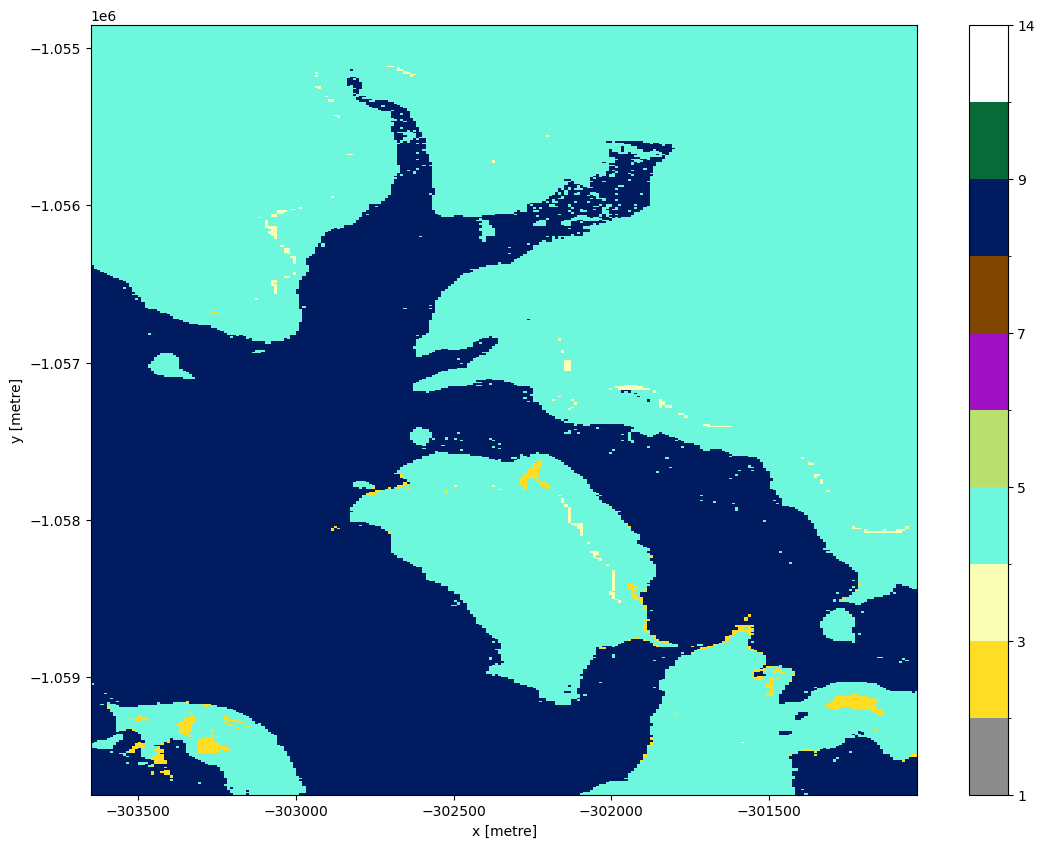

In [63]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [64]:
predicted_da.odc.explore()

In [65]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [66]:
predicted_da.odc.explore(cmap=c_map)

In [67]:
predicted_da.odc.write_cog("predicted_svm_bootless_ovo_15042025.tiff", overwrite=True)

PosixPath('predicted_svm_bootless_ovo_15042025.tiff')